# DQN with CartPole

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Set up

- $r = 1$ for every incremental timestep.
- $s_T = \text{2.4 units away from center or falls over too far}$ 

In [2]:
env = gym.make("CartPole-v1")

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
Transition = namedtuple("Transition",("state","action","next_state","reward"))

In [5]:
class ReplayMemory():
    def __init__(self,capacity):
        self.memory = deque([],maxlen = capacity)
    
    def push(self,*args):
        """transition save"""
        self.memory.append(Transition(*args))
    
    def sample(self,batch_size):
        """
        Input : batch_size
        Output : randomly sampled transitions in memory
        """
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)
        

## Q-network

In [6]:
class DQN(nn.Module):
    def __init__(self,n_obs,n_actions):
        super().__init__()
        self.layer1 = nn.Linear(n_obs,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64,n_actions)
        self.activation = nn.ReLU()
    def forward(self,x):
        l1_out = self.activation(self.layer1(x))
        l2_out = self.activation(self.layer2(l1_out))
        return self.layer3(l2_out)

dqn = DQN(32,10)
_t = torch.randn(10,32)
dqn(_t)[0]

tensor([-0.0175, -0.0064, -0.0310,  0.0675, -0.0197,  0.2433,  0.1908, -0.0816,
        -0.0720, -0.1309], grad_fn=<SelectBackward0>)

In [7]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [8]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1 * steps_done / EPS_DECAY) #ϵ의 상한,하한을 만드는 전략,이거써야겠다.
    steps_done += 1
    """
    if steps_done%10 == 0:
        print(eps_threshold,steps_done)
    """
    #ϵ-greedy policy
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]],device=device,dtype = torch.long)
    

_state = torch.randn(2,4).to(device)
print(_state)
_q_out = policy_net(_state)
print(_q_out)
_max_q = policy_net(_state).max(axis=1)
print(_max_q)

tensor([[ 0.4280,  0.3374, -0.6418,  0.9572],
        [ 0.1284,  1.3429,  0.0458,  0.7359]], device='cuda:0')
tensor([[ 0.0939, -0.0166],
        [ 0.0718,  0.0492]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([0.0939, 0.0718], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0, 0], device='cuda:0'))


In [9]:
episode_durations = []
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


- `optimize_model` functio n
    1. samples a batch $\sim \mathcal{D}$
    2. concatenate all the tensors into a single one
    3. compute Q and combines them into loss
    4. 

In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        # BATCH_SIZE보다 작을 경우 아예 다음 코드가 실행이 안됨.
        # 즉,Experience replay가 안됨.
        return
    global transitions,batch,_t,non_final_mask,non_final_next_states,state_batch\
    ,reward_batch,action_batch,state_action_values,non_final_next_states,__t,before_masked,after_masked\
    ,expected_state_action_values
    transitions = memory.sample(BATCH_SIZE)
    # 메모리에서 BATCH_SIZE만큼의 Transition들을 가져옴    
    _t = zip(*transitions)
    batch = Transition(*zip(*transitions))
    # Transition이라는 named tuple에 BATCH_SIZE만큼의 state,action ...를 따로따로 저장.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    # next_state가 Terminal이 아닌 state값들만 가져옴
    # Terminal이 None이므로 여기서는 None값을 제외한 next_state들을 가져옴
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # poicy_net은 현재 s_t,a_t에 대한 Q_value임.
    # 일단 현재 t에 대한 Q_value를 계산!
    #__t = policy_net(state_batch)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    """
    next_state_value를 계산하는 방법
    #1. terminal_state를 0 non_terminal_state를 1로 놓은 boolean tensor를 만든다.(mask)
    #2. 모든 state에 대한 value function인 target network를 가져오고
    #3. target network에서 mask를 활용하여 final state인 것은 value를 0으로 계산한다.
    # 이렇게 함으로 임의의 파라미터로 인한 target network가 Terminal state에 대한 value를 0이아닌 값을 주는 것을 막을 수 있다.
    """
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    #before_masked = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    # after_masked = next_state_values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


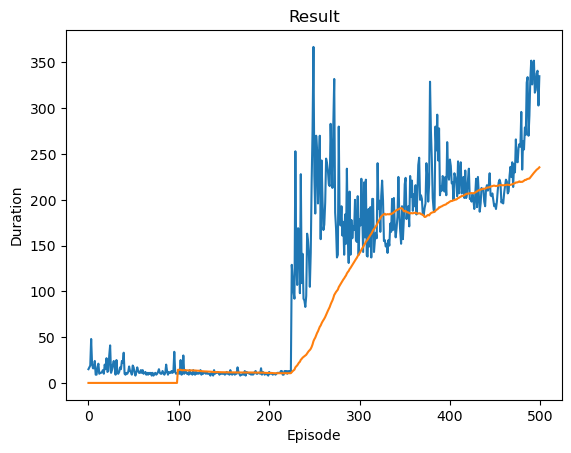

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [42]:
s,_ = env.reset()
policy_net(torch.tensor(s).to(device))

tensor([99.5481, 99.2072], device='cuda:0', grad_fn=<AddBackward0>)

# 코드 정리

## unpacking

In [12]:
def intro(name,age,univeristy_department):
    print(name,age,univeristy_department)

In [13]:
info = ["신호연",14,["HY","AI-semiconductor"]]

In [14]:
intro(info)

TypeError: intro() missing 2 required positional arguments: 'age' and 'univeristy_department'

- 함수는 3개의 파라미터에 대한 값(인자)를 필요로하는데 넣어주는 건 하나여서 오류 발생
- 리스트의 3개의 요소가 각각의 파라미터에 들어가는 인자가 되어야 함.
- 이때 unpacking, 즉 iterable한 객체안에 있는 요소를 input으로 넣어주는 역할

In [ ]:
intro(*info)

신호연 14 ['HY', 'AI-semiconductor']


## packing(*args , **kwargs)

In [ ]:
def hello(*args):
    print(args)
hello(1,2.5,"hi",True)

(1, 2.5, 'hi', True)


In [ ]:
def hello(**kwargs):
    print(kwargs)

In [ ]:
hello(kwargs1 = "g",kw = 2,age = 26)

{'kwargs1': 'g', 'kw': 2, 'age': 26}


## torch.gather

In [ ]:
t = torch.tensor([i+1 for i in range(9)]).reshape(3,3)
index = torch.tensor([[0,1,2],[1,2,0]])
torch.gather(t,dim=0,index=index)

tensor([[1, 5, 9],
        [4, 8, 3]])

In [ ]:
t

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
t = torch.tensor([i+1 for i in range(9)]).reshape(3,3)
index = torch.tensor([[0,1],[1,2]])
torch.gather(t,dim=1,index=index)

tensor([[1, 2],
        [5, 6]])

In [ ]:
[[1,2,]
,[5,6]
,[9,7]]

[[1, 2], [5, 6], [9, 7]]

In [ ]:
torch.gather(t,dim=1,index=torch.tensor([[1,1]]))

tensor([[2, 2]])

In [ ]:
t = torch.tensor([i for i in range(100)]).reshape(10,10)
index = torch.tensor([i for i in range(10)]*2).reshape(10,2)[:-3]
g_t = torch.gather(t,1,index)
print(t.shape,index.shape)
print(g_t)

torch.Size([10, 10]) torch.Size([7, 2])
tensor([[ 0,  1],
        [12, 13],
        [24, 25],
        [36, 37],
        [48, 49],
        [50, 51],
        [62, 63]])


In [ ]:
A = torch.tensor([i+1 for i in range(4)]).reshape(2,2)
torch.gather(A,index=index,dim=1).reshape(1,2)
index = torch.tensor([[0],[1]])
A.dim(),index.dim(),index,A.shape,index.shape

(2,
 2,
 tensor([[0],
         [1]]),
 torch.Size([2, 2]),
 torch.Size([2, 1]))

## map()

In [ ]:
# 리스트에 값을 하나씩 더해서 새로운 리스트를 만드는 작업
myList = [1, 2, 3, 4, 5]

# for 반복문 이용
result1 = []
for val in myList:
    result1.append(val + 1)

print(f'result1 : {result1}')


# map 함수 이용
def add_one(n):
    return n + 1


result2 = list(map(add_one, myList))  # map반환을 list 로 변환
print(f'result2 : {result2}')

result1 : [2, 3, 4, 5, 6]
result2 : [2, 3, 4, 5, 6]


In [ ]:
myList

result1 = []
for val in myList:
    result1.append(val+1)
print(result1)

[2, 3, 4, 5, 6]


In [ ]:
result2 = list(map(lambda x : x+1,myList))
result2

[2, 3, 4, 5, 6]

## zip()

In [ ]:
a = ["1",2]
b = [3,"5"]
c = [2,4]
for t in zip(a,b,c):
    print(t)

('1', 3, 2)
(2, '5', 4)


## torch.unsuqeeuze()

In [ ]:
import torch
ind_A  = torch.tensor([1,0,3])
ind_A.unsqueeze(1).unsqueeze(1) == ind_A.unsqueeze(1).unsqueeze(2)

tensor([[[True]],

        [[True]],

        [[True]]])

In [ ]:
torch.tensor([i for i in range(8)]).reshape(2,4)

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])

## check

In [ ]:
len(transitions)

128

In [ ]:
before_masked

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
after_masked

tensor([0.4509, 0.6724, 0.6550, 0.3936, 0.4086, 0.3233, 0.3974, 0.6300, 0.0000,
        0.3620, 1.1384, 0.3229, 0.4893, 0.9286, 0.3843, 0.4094, 0.3200, 0.6750,
        0.3486, 0.4730, 0.7877, 0.5478, 0.3448, 0.0000, 0.5176, 0.3613, 0.3535,
        0.3946, 0.8328, 0.3183, 0.4061, 0.3919, 0.3045, 0.3789, 0.7998, 0.8365,
        0.9102, 0.3106, 0.3463, 0.4299, 0.3520, 0.6124, 0.3324, 0.6185, 0.4004,
        0.3432, 0.6711, 0.3977, 0.3285, 0.6386, 0.3412, 0.7142, 0.5016, 0.3459,
        0.0000, 0.3325, 0.3951, 0.3529, 0.4550, 0.5403, 0.3315, 0.3641, 0.3638,
        0.6286, 0.3520, 0.4379, 0.3301, 0.7780, 0.3207, 0.4688, 0.0000, 0.4506,
        0.3452, 0.4396, 0.6683, 0.3663, 0.8068, 0.8672, 0.6586, 0.3427, 0.4015,
        0.3412, 0.6464, 0.8239, 0.3989, 0.3136, 1.3251, 0.5879, 0.3562, 0.3875,
        0.4905, 0.3174, 0.3465, 0.3737, 1.2304, 0.4512, 0.3386, 0.7941, 0.3301,
        0.3950, 0.3471, 0.3744, 1.0437, 0.3394, 0.3246, 0.5522, 0.3403, 0.4993,
        0.4461, 0.5644, 0.6235, 0.4678, 

In [ ]:
t = Transition(*zip(*transitions))

In [ ]:
t.next_state

(tensor([[ 0.1073,  1.7679, -0.1467, -2.5517]], device='cuda:0'),
 tensor([[ 0.0853,  1.2131, -0.1016, -1.8380]], device='cuda:0'),
 tensor([[-0.0783,  0.5542,  0.1493, -0.4089]], device='cuda:0'),
 tensor([[ 0.3524,  1.9037, -0.1091, -2.0654]], device='cuda:0'),
 tensor([[ 0.0199,  0.1916, -0.0173, -0.3075]], device='cuda:0'),
 tensor([[-0.0198,  0.4050,  0.0023, -0.5490]], device='cuda:0'),
 tensor([[ 0.0097,  0.3763,  0.0113, -0.3715]], device='cuda:0'),
 tensor([[-0.0265,  0.5466,  0.1104, -0.2387]], device='cuda:0'),
 tensor([[ 0.0936,  1.0071, -0.1436, -1.5632]], device='cuda:0'),
 tensor([[ 0.0229,  0.4268, -0.0829, -0.7092]], device='cuda:0'),
 tensor([[-0.0352, -0.0211, -0.0086, -0.0348]], device='cuda:0'),
 tensor([[ 0.0347,  0.6346, -0.1449, -1.1158]], device='cuda:0'),
 tensor([[ 0.1541,  0.8217, -0.1321, -1.1422]], device='cuda:0'),
 tensor([[ 0.1673,  1.3828, -0.1596, -2.1547]], device='cuda:0'),
 tensor([[-0.0433,  0.4303, -0.0228, -0.6093]], device='cuda:0'),
 tensor([[

In [ ]:
non_final_mask

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True],

In [ ]:
non_final_next_states

tensor([[ 1.0728e-01,  1.7679e+00, -1.4673e-01, -2.5517e+00],
        [ 8.5259e-02,  1.2131e+00, -1.0157e-01, -1.8380e+00],
        [-7.8343e-02,  5.5417e-01,  1.4926e-01, -4.0886e-01],
        [ 3.5235e-01,  1.9037e+00, -1.0908e-01, -2.0654e+00],
        [ 1.9913e-02,  1.9158e-01, -1.7274e-02, -3.0751e-01],
        [-1.9780e-02,  4.0505e-01,  2.3448e-03, -5.4902e-01],
        [ 9.7404e-03,  3.7633e-01,  1.1278e-02, -3.7153e-01],
        [-2.6455e-02,  5.4661e-01,  1.1037e-01, -2.3874e-01],
        [ 9.3618e-02,  1.0071e+00, -1.4358e-01, -1.5632e+00],
        [ 2.2926e-02,  4.2684e-01, -8.2918e-02, -7.0916e-01],
        [-3.5185e-02, -2.1130e-02, -8.5862e-03, -3.4842e-02],
        [ 3.4693e-02,  6.3463e-01, -1.4485e-01, -1.1158e+00],
        [ 1.5410e-01,  8.2174e-01, -1.3214e-01, -1.1422e+00],
        [ 1.6725e-01,  1.3828e+00, -1.5965e-01, -2.1547e+00],
        [-4.3299e-02,  4.3027e-01, -2.2846e-02, -6.0928e-01],
        [-2.8509e-02,  5.7321e-01,  5.8367e-02, -7.0439e-01],
        

In [ ]:
state_batch.shape

torch.Size([128, 4])

In [ ]:
action_batch.shape

torch.Size([128, 1])

In [ ]:
reward_batch

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.], device='cuda:0')

In [ ]:
__t

tensor([[0.8239, 1.0678],
        [1.5102, 1.8625],
        [1.1531, 1.4095],
        [0.7606, 1.0270],
        [0.7679, 1.0549],
        [0.7800, 0.9981],
        [0.9312, 1.3687],
        [1.0128, 1.3304],
        [1.6723, 2.1253],
        [0.7289, 0.9694],
        [1.7867, 2.2589],
        [0.7771, 1.0487],
        [1.1555, 1.4792],
        [1.4739, 1.8754],
        [0.7970, 1.0090],
        [0.8166, 1.0341],
        [0.7520, 0.9775],
        [1.4251, 1.8186],
        [0.7406, 0.9626],
        [0.8206, 1.0935],
        [1.2606, 1.6089],
        [0.9438, 1.2157],
        [0.7455, 0.9680],
        [1.5628, 1.9837],
        [0.8967, 1.1652],
        [0.7654, 0.9682],
        [0.8783, 1.1400],
        [0.7707, 1.0308],
        [1.4016, 1.7157],
        [0.7585, 1.0263],
        [0.7604, 1.0498],
        [0.7715, 1.0034],
        [0.7650, 1.0434],
        [1.0396, 1.2708],
        [1.2695, 1.6362],
        [1.3621, 1.7203],
        [1.4564, 1.8477],
        [0.7637, 1.0681],
        [0.7

In [ ]:
expected_state_action_values

tensor([2.2928, 1.9625, 1.4207, 2.1499, 1.4084, 1.4506, 1.4171, 1.4036, 1.8529,
        1.5080, 1.3836, 1.6617, 1.6917, 2.1036, 1.4724, 1.4929, 1.3812, 1.8639,
        1.4004, 1.3794, 1.3526, 1.6855, 1.7178, 1.3750, 1.5543, 1.0000, 1.4032,
        1.5156, 1.7385, 1.4519, 1.6601, 1.4305, 1.5354, 1.3849, 1.4020, 1.3803,
        1.4091, 1.6270, 1.4476, 1.4067, 1.3784, 1.4689, 1.3721, 1.3883, 1.4954,
        1.3855, 1.3683, 1.4826, 1.8911, 1.4277, 1.7251, 1.3977, 1.4022, 1.7976,
        1.4444, 1.4073, 1.4701, 1.4811, 1.3793, 1.8667, 1.4113, 1.4553, 1.4508,
        1.9791, 1.4284, 1.8901, 1.3705, 1.5423, 1.0000, 2.1070, 1.4011, 1.4223,
        1.4908, 1.3795, 1.0000, 1.3712, 1.6187, 1.4180, 1.3797, 1.6121, 2.2511,
        1.3996, 1.3766, 1.4590, 1.7936, 1.4091, 1.4084, 1.3822, 1.4698, 1.6433,
        1.9002, 1.4589, 1.6349, 1.6177, 1.3832, 1.3732, 1.3877, 1.3816, 1.3966,
        1.6092, 1.3519, 2.2492, 1.4199, 1.4088, 1.4035, 1.4505, 2.4448, 1.4024,
        1.7346, 1.5550, 1.5385, 1.4438, 